In [174]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np

import catboost as cat
import xgboost as xgb

from scipy.fft import fft, fftfreq
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.cluster import OPTICS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.feature_selection import SelectKBest, f_regression, f_classif, RFE, SelectFromModel
from sklearn.metrics import mean_squared_error


In [4]:
df = pd.read_csv('./final_dataset.csv').drop(columns=['Unnamed: 0'])
df['t'] = pd.to_datetime(df['t'])
df = df.set_index(['t', 'symbol'])
df = df.sort_index()
df.head()

,,o,h,l,c,v,n,vw,diff,emaS,emaM,...,time_embed_month_sin,time_embed_month_cos,time_embed_year_sin,time_embed_year_cos,market_correlation,market_long_term_trend,market_short_term_trend,market_change,alpha,beta
t,symbol,,,,,,,,,,,,,,,,,,,,,
2018-01-02 09:00:00,BABA,173.46,173.90,173.03,173.77,12094,92,173.478710,1.004939,1.000886,1.000067,...,0.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:00,BABA,173.90,174.00,173.83,174.00,7456,28,173.896286,1.002407,1.001139,1.000127,...,0.008727,0.999962,0.000717,1.000000,1.000000,1.000046,1.000046,NaN,NaN,NaN
2018-01-02 11:00:00,BABA,174.15,174.70,174.02,174.58,9966,93,174.341312,1.002559,1.001376,1.000190,...,0.017452,0.999848,0.001435,0.999999,0.895350,1.000505,1.000540,0.697924,NaN,NaN
2018-01-02 12:00:00,BABA,174.50,174.98,174.25,174.72,65516,405,174.598031,1.001473,1.001392,1.000223,...,0.026177,0.999657,0.002152,0.999998,0.933935,1.000610,1.000648,0.417496,NaN,NaN
2018-01-02 13:00:00,BABA,174.68,175.33,174.40,175.00,105976,696,174.928519,1.001893,1.001475,1.000265,...,0.034899,0.999391,0.002869,0.999996,0.963070,1.000622,1.000650,0.082915,NaN,NaN


/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_1624/1698103233.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['category'], dtype='object')
  np.log(df.groupby('symbol').get_group('TSLA').ewm(span=500).mean().abs()['pc12']).plot()


<AxesSubplot:xlabel='t,symbol'>

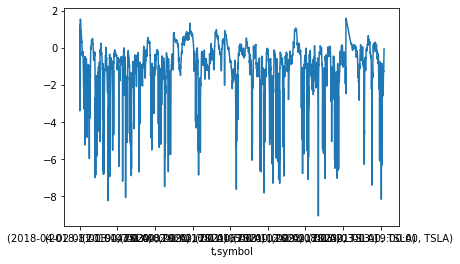

In [102]:
np.log(df.groupby('symbol').get_group('TSLA').ewm(span=500).mean().abs()['pc12']).plot()

<AxesSubplot:>

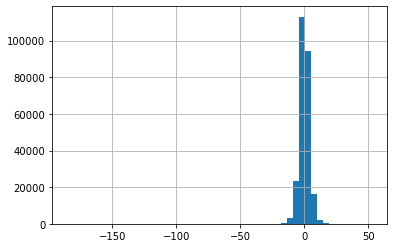

In [135]:
df['pc12'].hist(bins=50)

In [110]:
df.reset_index()
df = df.sort_values('pc12')
df['pc12'].head(50)

t                    symbol
2020-08-28 16:00:00  AAPL     -184.750071
2020-08-28 23:00:00  AAPL     -184.596963
2020-08-28 19:00:00  AAPL     -184.265316
2020-08-28 15:00:00  AAPL     -184.231121
2020-08-28 18:00:00  AAPL     -184.055697
2020-08-28 17:00:00  AAPL     -183.823395
2020-08-28 22:00:00  AAPL     -183.693278
2020-08-28 14:00:00  AAPL     -183.454955
2020-08-28 20:00:00  AAPL     -183.117767
2020-08-28 21:00:00  AAPL     -183.108576
2020-08-28 13:00:00  AAPL     -182.843224
2020-08-28 12:00:00  AAPL     -182.328986
2022-07-15 23:00:00  GOOG     -167.303292
2022-07-15 21:00:00  GOOG     -166.804772
2022-07-15 20:00:00  GOOG     -166.225505
2022-07-15 19:00:00  GOOG     -165.731233
2022-07-15 18:00:00  GOOG     -165.239768
2022-07-15 17:00:00  GOOG     -164.780019
2022-07-15 15:00:00  GOOG     -164.267377
2022-07-15 16:00:00  GOOG     -164.259897
2022-07-15 12:00:00  GOOG     -163.780775
2022-07-15 14:00:00  GOOG     -163.727541
2021-07-19 12:00:00  NVDA     -163.433484
2022-0

In [106]:
df['pc12'].tail()

t                    symbol
2023-02-01 10:00:00  META      51.484519
2023-02-01 20:00:00  META      52.084823
2023-02-01 12:00:00  META      52.233970
2023-02-01 13:00:00  META      52.360424
2023-02-01 19:00:00  META      52.801748
Name: pc12, dtype: float64

In [95]:
df.sort_values('pc12')
top_value = df['pc12'].quantile(0.95)
bottom_value = df['pc12'].quantile(0.05)

df['category'] = 'middle'
df.loc[df['pc12'] > top_value, 'category'] = 'top'
df.loc[df['pc12'] < bottom_value, 'category'] = 'bottom'

In [180]:
from scipy.stats import norm
df = df.sort_index()

# Define the threshold percentile
threshold_percentile = 4

# Compute the rolling mean and standard deviation for each symbol
df['rolling_mean'] = df.groupby('symbol')['pc12'].transform(lambda x: x.rolling(window=77).mean())
df['rolling_std'] = df.groupby('symbol')['pc12'].transform(lambda x: x.rolling(window=77).std())

# Compute the upper and lower threshold values for each symbol
df['upper_threshold'] = df['rolling_mean'] + df['rolling_std'] * norm.ppf(1 - threshold_percentile / 100)
df['lower_threshold'] = df['rolling_mean'] - df['rolling_std'] * norm.ppf(1 - threshold_percentile / 100)

# Assign the category based on the thresholds
df['category'] = 'middle'
df.loc[df['pc12'] > df['upper_threshold'], 'category'] = 'top'
df.loc[df['pc12'] < df['lower_threshold'], 'category'] = 'bottom'

df['category'] = df['category'].astype('category')

# Drop the intermediate columns
df.drop(['rolling_mean', 'rolling_std', 'upper_threshold', 'lower_threshold'], axis=1, inplace=True)

In [181]:
df.value_counts('category') / len(df)

category
middle    0.880318
bottom    0.061377
top       0.058305
dtype: float64

In [182]:
df.index.get_level_values('t').min()
df.index.get_level_values('t').max()

timestamps = df.index.get_level_values('t')
min_timestamp = timestamps.min()
max_timestamp = timestamps.max()

# Find the timestamp that is 80% of the way between the min and max
threshold_timestamp = min_timestamp + 0.8 * (max_timestamp - min_timestamp)
print("80% division timestamp:", threshold_timestamp)

80% division timestamp: 2022-03-14 01:00:00


---

In [183]:
"""
columns = [
    'pc', 'emaL', 'emaS', 'mvS', 'rsi', 'macds', 'lavs', 'Net_Profit_Margin', 'market_correlation',
    'Gross_Margin', 'P/E', 'time_embed_year_sin', 'time_embed_year_cos', 'financial_data_age', 'obvmL'
]
"""
columns = df.columns

In [184]:
data = df[columns].dropna()
data_train = data[data.index.get_level_values('t') <= threshold_timestamp]
data_test = data[data.index.get_level_values('t') > threshold_timestamp]

In [185]:
k = data_train.value_counts('category').min()
downsampled_df = pd.DataFrame()
for category in data_train['category'].unique():
    sampled_rows = data_train[data_train['category'] == category].sample(k)
    downsampled_df = downsampled_df.append(sampled_rows)

print(downsampled_df.shape)
downsampled_df.value_counts('category')

(28485, 69)


/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_1624/2876518345.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  downsampled_df = downsampled_df.append(sampled_rows)
/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_1624/2876518345.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  downsampled_df = downsampled_df.append(sampled_rows)
/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_1624/2876518345.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  downsampled_df = downsampled_df.append(sampled_rows)


category
bottom    9495
middle    9495
top       9495
dtype: int64

In [186]:
# X = data[columns].drop(columns=['pc12'])
# y = data['pc12']

X_train = downsampled_df[columns].drop(columns=['pc12', 'category'])
y_train = downsampled_df['category']
X_test = data_test[columns].drop(columns=['pc12', 'category'])
y_test = data_test['category']

labels_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(labels_scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(labels_scaler.transform(X_test), columns=X_train.columns)

# targets_scaler = StandardScaler()
# y_train_scaled = targets_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
# y_test_scaled = targets_scaler.transform(y_test.to_numpy().reshape(-1, 1))

print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(28485, 67)
(50098, 67)
(28485,)
(50098,)


In [187]:
X_train_scaled.isna().sum()

o                0
h                0
l                0
c                0
v                0
                ..
market_change    0
alpha            0
beta             0
max_threshold    0
min_threshold    0
Length: 67, dtype: int64

In [ ]:
cat.cv(
    cat.Pool(
        X_train_scaled[[
            'emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 
            'market_short_term_trend', 'alpha'
        ]],
        y_train
    ),
    {
        'learning_rate': 0.001,
        'iterations': 40000,
        'loss_function': 'CrossEntropy',
        # 'early_stopping_rounds': 100,
    },
    fold_count=5,
    shuffle=False,
    plot=True,
    verbose=2000
)

In [190]:
model = cat.CatBoostClassifier(
    iterations=40000,
    learning_rate=0.1,
    # early_stopping_rounds=1000,
    loss_function='MultiClass',
    classes_count=3,
    verbose=1000
)

xcols = [
    'emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 
    'market_short_term_trend', 'alpha'
]
model.fit(
    cat.Pool(
        X_train_scaled[xcols],
        pd.get_dummies(y_train)
    ),
    eval_set=cat.Pool(X_test_scaled[xcols], pd.get_ y_test),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: catboost/private/libs/target/data_providers.cpp:612: Currently only multi-regression, multilabel and survival objectives work with multidimensional target

In [191]:
pd.options.display.float_format = "{:,.3f}".format

def plot_predictions(train_predictions, train_targets, test_predictions, test_targets):
    plt.figure(figsize=(12, 6))
    sn.set_style("whitegrid")

    plt.scatter(train_targets.flatten(), train_predictions.flatten(), alpha=0.5, label="Train")
    plt.scatter(test_targets.flatten(), test_predictions.flatten(), alpha=0.5, label="Test")

    targets = np.concatenate((train_targets, test_targets)).flatten()
    predictions = np.concatenate((train_predictions, test_predictions)).flatten()

    lin_reg = LinearRegression()
    lin_reg.fit(targets.reshape(-1, 1), predictions.reshape(-1, 1))
    y_pred_reg = lin_reg.predict(targets.reshape(-1, 1))

    plt.plot(targets, y_pred_reg, color='red', linestyle='--', label='Linear regression')

    plt.xlabel('Expected Value')
    plt.ylabel('Predicted Value')
    plt.title('Scatter Plot of Expected Value vs Predicted Value')
    
    # plt.xlim((-50, 50))
    # plt.ylim((0, 5))
    
    plt.legend()
    plt.show()

def print_metrics(train_predictions, train_targets, test_predictions, test_targets):
    results = {}

    for name, pred, targ in zip(
        ["Train", "Test"],
        [train_predictions, test_predictions],
        [train_targets, test_targets],
    ):
        results[name] = {
            "r2": r2_score(targ.flatten(), pred.flatten()),
            "rmse": np.sqrt(mean_squared_error(targ.flatten(), pred.flatten())),
            "mae": mean_absolute_error(targ.flatten(), pred.flatten()),
            "mse": mean_squared_error(targ.flatten(), pred.flatten()),
        }

    return pd.DataFrame(results)

In [192]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)
y_pred = rf_classifier.predict(X_test_scaled)

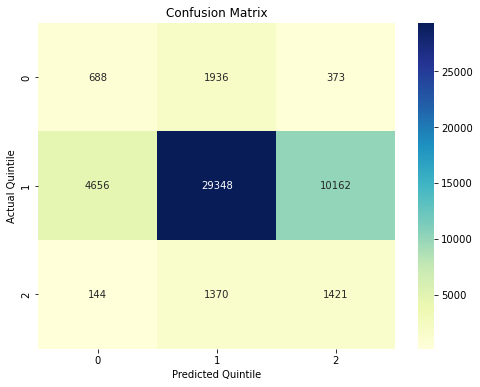

In [193]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
ax.set_xlabel("Predicted Quintile")
ax.set_ylabel("Actual Quintile")
ax.set_title("Confusion Matrix")
plt.show()

---

In [175]:
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train, y_train)
X_test_kbest = kbest.transform(X_test)
column_names_skb = X_train.columns[kbest.get_support()]
print(f"Columns selected by SelectKBest:\n -> {list(column_names_skb)}")

Columns selected by SelectKBest:
 -> ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 'market_short_term_trend', 'alpha']


In [63]:
model = RandomForestRegressor(
    max_depth=5,
    n_estimators=400,
    min_samples_split=2,
    verbose=True,
    n_jobs=-1
)

print("Fitting RF")
model.fit(X_train, y_train)

print("Selecting attrs")
selector = SelectFromModel(model, prefit=True, max_features=10)  # Choose the top 10 features
X_train_importance = selector.transform(X_train)
X_test_importance = selector.transform(X_test)

column_names_importance = X.columns[selector.get_support()]
print("Columns selected by feature importance:", column_names_importance)

Fitting RF


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min


Selecting attrs
Columns selected by feature importance: Index(['emaL', 'std', 'obvmS', 'obvmL', 'obvSH', 'lavgv', 'macd_std',
       'financial_data_age', 'spy_value', 'time_embed_year_cos'],
      dtype='object')


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.3min finished
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [65]:
rfe = RFE(
    RandomForestRegressor(
        max_depth=5,
        n_estimators=50,
        min_samples_split=2,
        verbose=True,
        n_jobs=-1
    ),
    n_features_to_select=10
)
rfe.fit(X_train_scaled, y_train_scaled)
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

column_names_rfe = X.columns[rfe.get_support()]
print("Columns selected by RFE:", column_names_rfe)

/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.0s finished
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  

Columns selected by RFE: Index(['emaL', 'std', 'obvmS', 'obvmL', 'ewm_26', 'financial_data_age',
       'spy_value', 'time_embed_year_sin', 'time_embed_year_cos',
       'market_correlation'],
      dtype='object')


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished


# All data

- selection 1: [
    'diff', 'pc', 'rsi', 'rsid', 'macds', 'financial_data_age', 'time_embed_week_sin',
    'time_embed_week_cos', 'time_embed_month_cos', 'market_change'
]
- selection 2: [
    'emaL', 'std', 'obvmS', 'obvmL', 'obvSH', 'lavgv', 'macd_std',
    'financial_data_age', 'spy_value', 'time_embed_year_cos'
]
- selection 3: [
    'emaL', 'std', 'obvmS', 'obvmL', 'ewm_26', 'financial_data_age',
    'spy_value', 'time_embed_year_sin', 'time_embed_year_cos', 'market_correlation'
]

---

# Only big ops



---

In [ ]:
top_value = df['pc12'].quantile(0.95)
bottom_value = df['pc12'].quantile(0.05)

df['category'] = 'middle'
df.loc[df['pc12'] > top_value, 'category'] = 'top'
df.loc[df['pc12'] < bottom_value, 'category'] = 'bottom'